In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
from tqdm import tqdm

In [2]:
def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

train_path = '../data/seg_train/'
test_path = '../data/seg_test/'

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 501/501 [00:03<00:00, 146.76it/s]


In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
176/176 [==============================] - 99s 551ms/step - loss: 1.2261 - accuracy: 0.5244 - val_loss: 0.8749 - val_accuracy: 0.6772
Epoch 2/10
176/176 [==============================] - 90s 512ms/step - loss: 0.8473 - accuracy: 0.6865 - val_loss: 0.7106 - val_accuracy: 0.7471
Epoch 3/10
176/176 [==============================] - 90s 510ms/step - loss: 0.7203 - accuracy: 0.7417 - val_loss: 0.6414 - val_accuracy: 0.7674
Epoch 4/10
176/176 [==============================] - 88s 501ms/step - loss: 0.6340 - accuracy: 0.7715 - val_loss: 0.5986 - val_accuracy: 0.7919
Epoch 5/10
176/176 [==============================] - 88s 500ms/step - loss: 0.5729 - accuracy: 0.7965 - val_loss: 0.5369 - val_accuracy: 0.8058
Epoch 6/10
176/176 [==============================] - 86s 491ms/step - loss: 0.4970 - accuracy: 0.8244 - val_loss: 0.5584 - val_accuracy: 0.8055
Epoch 7/10
176/176 [==============================] - 87s 496ms/step - loss: 0.4337 - accuracy: 0.8411 - val_loss: 0.5414 - val_ac

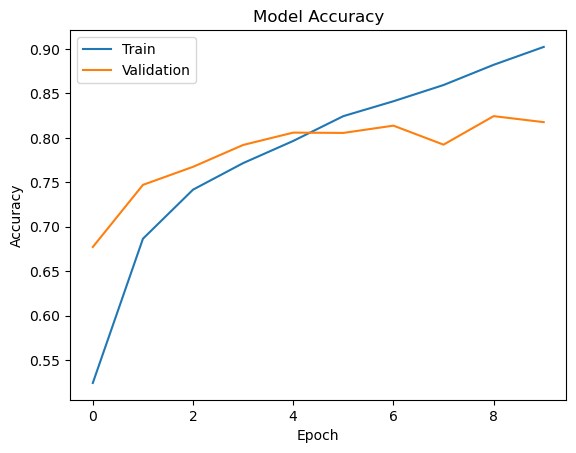

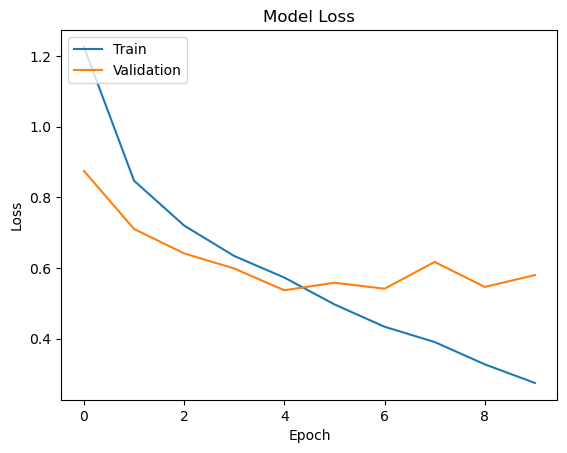

In [5]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)

print('Accuracy: ', accuracy)
print('Loss: ', loss)

94/94 [==============================] - 6s 62ms/step - loss: 0.5695 - accuracy: 0.8180
Accuracy:  0.8180000185966492
Loss:  0.5695407390594482


Test Set Evaluation Metrics
Confusion Matrix:  [[348   4   3   6   8  68]
 [  8 440   0   3   0  23]
 [ 11   5 382 116  27  12]
 [  7   2  39 451  21   5]
 [ 11   3  27  63 399   7]
 [ 56   3   2   4   2 434]]
F1 Score:  0.8182954756806571
Precision:  0.8257002891996735
Recall:  0.818
Accuracy:  0.818


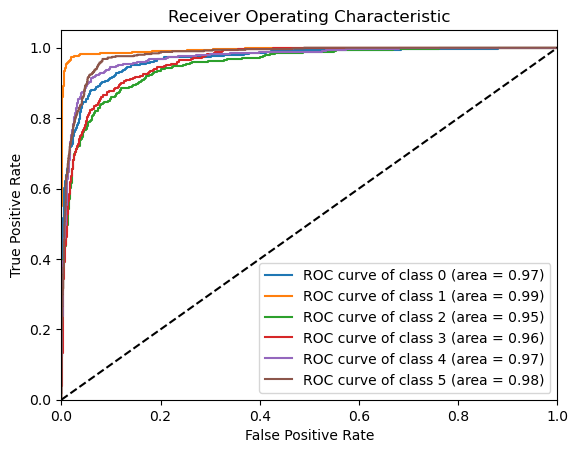

In [7]:
from sklearn.metrics import f1_score,confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)

y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

confusion_matrix = confusion_matrix(y_test, y_pred)
print('Test Set Evaluation Metrics')
print('Confusion Matrix: ', confusion_matrix)

print('F1 Score: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('Loss: ', loss)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 6

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

